# PyTorch Tutorial - Deep learning framework

### EE-556: Mathematics of Data: From Theory to Computation. Instructor: Prof. Volkan Cevher


This tutorial introduces the basics for working with deep learning methods in PyTorch.

## Defining a neural network architecture

In PyTorch it is easy to define a network architecture. We only have to define a subclass of the `torch.nn.Module` class and implement a forward method that defines the output of the network given an input. We can reuse the components in the `torch.nn` submodule and the functions in the `torch.nn.functional` submodule. The following example shows how to define a two-layer fully connected network with ReLU activations.

In [1]:
import torch
import torch.nn.functional as F
from torch import nn

class TwoLayerNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        """
        Create two nn.Linear objects and assign them as attributes
        :param input_dim: dimension of the input
        :param hidden_dim: number of hidden neurons
        :param output_dim: dimension of the output
        """
        super().__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        """
        In the forward method we define what is the output of the network
        given an input x. In this example we use the ReLU as our activation function
        """
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

Now we can create an instance of the architecture we just defined, and compute its output on some tensor. Notice that we can pass different values for the input dimension, number of hidden neurons and output dimension when creating an instance of the class.

In [2]:
net = TwoLayerNet(input_dim=784, hidden_dim=100, output_dim=10)
x = torch.randn(784)
result = net(x)
print('Output of the network at input x:', result)


Output of the network at input x: tensor([ 0.0964, -0.0889,  0.0039,  0.0765,  0.4046, -0.3576, -0.0808, -0.2414,
        -0.0047,  0.1155], grad_fn=<ViewBackward0>)



## Accessing the parameters of the layers

Most often we want to directly modify the parameters of a network. Depending on the type of modules you use to define your network, this procedure might be different. We will show how to clip the values of the weight and biases of linear layers in the following example:


In [3]:

net = TwoLayerNet(input_dim=784, hidden_dim=100, output_dim=10)
net.linear1.weight.data = torch.clip(net.linear1.weight.data, min=-1., max=1.)
net.linear1.bias.data = torch.clip(net.linear1.bias.data, min=-1., max=1.)
net.linear2.weight.data = torch.clip(net.linear2.weight.data, min=-1., max=1.)
net.linear2.bias.data = torch.clip(net.linear2.bias.data, min=-1., max=1.)

In this example, the linear layers have two attributes weight and bias where the actual tensors are stored. Note that we modify the data attribute which stores the raw values of the tensor, so that this operation is not taken into account when computing derivatives. Recall that PyTorch keeps track of all operations involving tensors that have the attribute `requires_grad` set to True.


## Loading the training data

PyTorch implements several classes that make it easy to work with large datasets. Also, the `torchvision` module lets us download popular benchmark datasets. The following example shows how to load the MNIST dataset, and create two instances of `torch.utils.data.DataLoader`, which is an object that lets us iterate through the dataset in batches. Because MNIST consists of image-label pairs, each batch is made of a tensor containing the images, and a tensor containing the corresponding labels.


In [4]:
import torch, torchvision
from torchvision import transforms

train_dataset = torchvision.datasets.MNIST(
    root='.',  # Replace with your desired data path
    train=True,
    transform=transforms.ToTensor(),
    download=True)

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=100,
    shuffle=True)

for a, b in train_loader:
    print('Batch size:', a.shape[0])
    print('Input dimension:', a[0].shape)

Batch size: 100
Input dimension: torch.Size([1, 28, 28])
Batch size: 100
Input dimension: torch.Size([1, 28, 28])
Batch size: 100
Input dimension: torch.Size([1, 28, 28])
Batch size: 100
Input dimension: torch.Size([1, 28, 28])
Batch size: 100
Input dimension: torch.Size([1, 28, 28])
Batch size: 100
Input dimension: torch.Size([1, 28, 28])
Batch size: 100
Input dimension: torch.Size([1, 28, 28])
Batch size: 100
Input dimension: torch.Size([1, 28, 28])
Batch size: 100
Input dimension: torch.Size([1, 28, 28])
Batch size: 100
Input dimension: torch.Size([1, 28, 28])
Batch size: 100
Input dimension: torch.Size([1, 28, 28])
Batch size: 100
Input dimension: torch.Size([1, 28, 28])
Batch size: 100
Input dimension: torch.Size([1, 28, 28])
Batch size: 100
Input dimension: torch.Size([1, 28, 28])
Batch size: 100
Input dimension: torch.Size([1, 28, 28])
Batch size: 100
Input dimension: torch.Size([1, 28, 28])
Batch size: 100
Input dimension: torch.Size([1, 28, 28])
Batch size: 100
Input dimension

Note that the batch of data is the tensor `a` which has dimensions batch_size × input_dimension. In our particular example we have chosen a batch size of 100 and the MNIST images have dimension 28×28. The network we defined in section 2 has an input dimension of 784 = 28 x 28. In order to reshape the batch tensor `a` as a tensor of dimensions batch_size × 784 we can use the following:
`a = a.view(a.shape[0], -1)`.
With this shape we can feed the tensor to our network.
We now visualize some examples from the MNIST dataset.


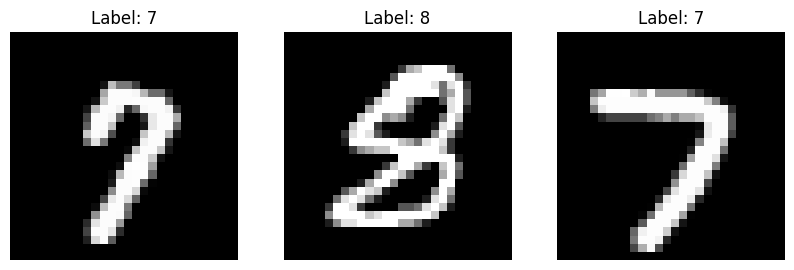

In [5]:
import matplotlib.pyplot as plt

# Get 3 examples from the dataset
examples = iter(train_loader)
images, labels = next(examples)

# Plot the images
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
for i in range(3):
    axes[i].imshow(images[i].numpy().squeeze(), cmap='gray')
    axes[i].set_title(f'Label: {labels[i].item()}')
    axes[i].axis('off')

plt.show()


## Defining a loss function and obtaining its gradient with respect to the network's parameters

Now that we have a neural network architecture and some labeled data, we turn to the task of choosing a set of parameters that make the network perform well on the image classification task. One popular loss function for image classification is the cross-entropy loss, and PyTorch makes it easy to obtain the gradient of such a function with respect to each of the network's parameters, in order to use first-order optimization methods. In the following example we will obtain the gradient on each mini-batch of the training data:


In [6]:
for a, b in train_loader:
    loss_fn = nn.CrossEntropyLoss()
    a = a.view(a.shape[0], -1)
    net.zero_grad() # set the gradients to 0
    output = net(a)
    loss = loss_fn(output, b)
    loss.backward() # backpropagation
    for p in net.parameters():
        gradient = p.grad

Notice that the gradient is stored as an attribute `p.grad` on each of the network's parameters. Also, we have to set all the gradients to zero with the line `net.zero_grad()`. This is because everytime the method `loss.backward()` is called, the gradients are accumulated rather than replaced.



## Using Pytorch's Optimizer class

In order to provide useful abstractions for an optimization algorithm, PyTorch provides the Optimizer interface as well as different classes implementing well known methods like SGD or ADAM.

An optimizer takes as input a list of variables for an optimization problem (usually the parameters of a PyTorch module), and the hyperparameters of the optimization algorithm. 

The Optimizer class works by calling two different methods `optimizer.zero_grad()` and `optimizer.step()`. The first one sets as zero all the gradients corresponding to the variables that were assigned at initialization (in this case, the network's parameters), and the second one updates the variables according to some rule. In the case of SGD this just means subtracting a multiple of the gradient from each variable. For example if we want to train the weights of our neural network with SGD and learning rate (step size) 0.1 we would initialize an optimizer and write a typical training loop as follows:


Loss: 0.5223714760442575
Loss: 0.2764257527887821
Loss: 0.22273141620059808
Loss: 0.1863413620988528
Loss: 0.16030733563626806
Loss: 0.1402264552252988
Loss: 0.12440013649562995
Loss: 0.11180179509955147
Loss: 0.10145463613482814
Loss: 0.09289616520516575


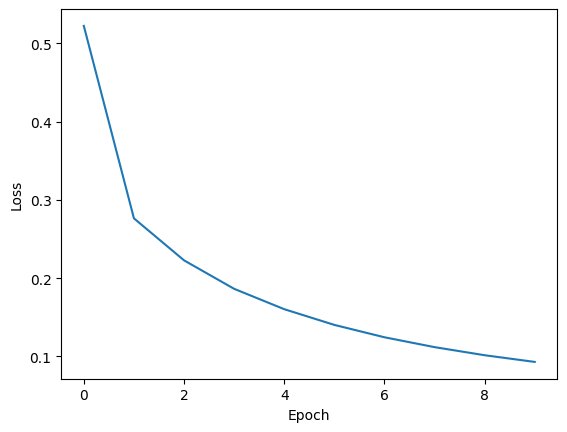

In [7]:
from torch import optim
import numpy as np

optimizer = optim.SGD(net.parameters(), lr=0.1)
loss_history = []

for epoch in range(10):
    loss_avg = []
    for a, b in train_loader:
        loss_fn = nn.CrossEntropyLoss()
        a = a.view(a.shape[0], -1) # reshape 100x28x28 batch of images to a 100x784 tensor
        optimizer.zero_grad() # set the gradients to 0
        output = net(a)
        loss = loss_fn(output, b) # compute loss function
        loss.backward() # backpropagation
        optimizer.step()  # update
        loss_avg.append(loss.item())

    # Logging loss
    loss_history.append(np.mean(loss_avg))
    print(f'Loss: {loss_history[-1]}')

# Plotting the loss
import matplotlib.pyplot as plt
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Some useful low-level functions

* `torch.zeros(*sizes)`: returns a tensor of zeros with dimensions specified by a list of integers.
* `torch.ones(*sizes)`: similar to torch.zeros
* `torch.sqrt(x)`: returns the element-wise square root of the tensor x.
* `(*, **, /, +, -)`: python's math operators work element-wise with tensors.
* see [https://pytorch.org/docs/stable/torch.html#math-operations](https://pytorch.org/docs/stable/torch.html#math-operations) for a complete review of PyTorch low-level functions.